# Regression Discontinuity Design Analysis Example

This notebook demonstrates how to use the causal inference library for comprehensive Regression Discontinuity Design (RDD) analysis.

## Overview
Regression Discontinuity Design exploits arbitrary cutoffs in treatment assignment to identify causal effects. It's particularly useful when treatment is assigned based on a continuous score crossing a threshold.

In [1]:
# Import necessary libraries
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add the parent directory to the path
sys.path.append(os.path.join(os.path.dirname(os.getcwd()), '..'))

from causal_inference.methods import RegressionDiscontinuityDesign
from causal_inference.datasets import generate_rdd_data

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)

## 1. Generate Synthetic Data

We'll create synthetic RDD data with a clear discontinuity at the cutoff.

In [2]:
# Generate synthetic RDD data
print("Generating synthetic RDD data...")
data = generate_rdd_data(
    n_obs=1000,              # Number of observations
    cutoff=0.0,              # Treatment cutoff
    treatment_effect=3.0,    # True treatment effect
    noise_std=1.5,           # Noise level
    polynomial_degree=2,     # Polynomial relationship
    random_seed=42           # For reproducibility
)

print(f"Generated data with {len(data)} observations")
print(f"Running variable range: [{data['running_var'].min():.2f}, {data['running_var'].max():.2f}]")
print(f"Treatment rate: {data['treated'].mean():.2%}")
print("\nFirst few rows:")
data.head(10)

Generating synthetic RDD data...
Generated data with 1000 observations
Running variable range: [-2.97, 3.00]
Treatment rate: 49.70%

First few rows:


,running_var,treated,outcome
0,-2.972208,0,2.784716
1,-2.969630,0,0.388415
2,-2.966867,0,-0.238939
3,-2.958287,0,1.676948
4,-2.944818,0,-1.041968
5,-2.934974,0,0.349081
6,-2.934025,0,2.314086
7,-2.931878,0,3.199589
8,-2.927073,0,1.174723
9,-2.921988,0,2.170976


## 2. Exploratory Data Analysis

Let's visualize the data and examine the discontinuity.

Data Summary:
       running_var      treated      outcome
count  1000.000000  1000.000000  1000.000000
mean     -0.058461     0.497000     2.378298
std       1.752824     0.500241     2.750568
min      -2.972208     0.000000    -4.522618
25%      -1.584160     0.000000     0.126303
50%      -0.019156     0.000000     2.209841
75%       1.465918     1.000000     4.463193
max       2.998306     1.000000    10.013863


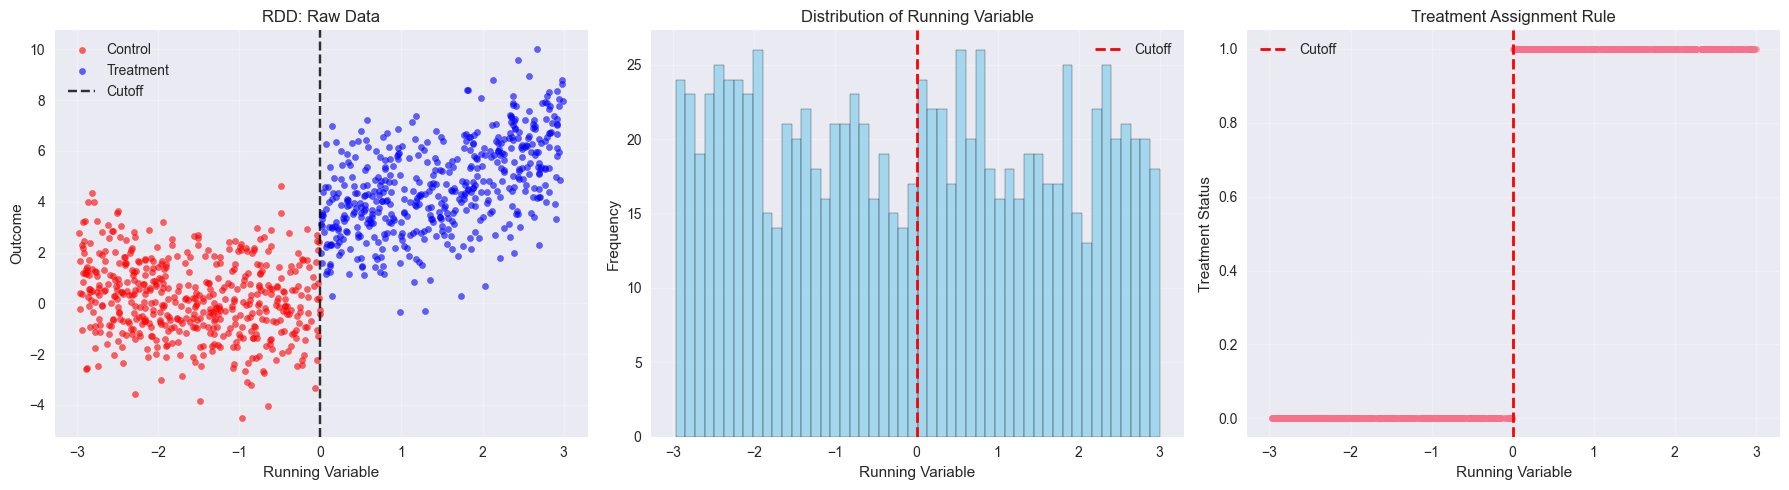

In [3]:
# Basic statistics
print("Data Summary:")
print(data.describe())

# Visualize the raw data
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Scatter plot of outcome vs running variable
control_data = data[data['treated'] == 0]
treatment_data = data[data['treated'] == 1]

axes[0].scatter(control_data['running_var'], control_data['outcome'], 
               alpha=0.6, s=20, color='red', label='Control')
axes[0].scatter(treatment_data['running_var'], treatment_data['outcome'], 
               alpha=0.6, s=20, color='blue', label='Treatment')
axes[0].axvline(x=0, color='black', linestyle='--', alpha=0.8, label='Cutoff')
axes[0].set_xlabel('Running Variable')
axes[0].set_ylabel('Outcome')
axes[0].set_title('RDD: Raw Data')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Histogram of running variable
axes[1].hist(data['running_var'], bins=50, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Cutoff')
axes[1].set_xlabel('Running Variable')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Running Variable')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Plot 3: Treatment assignment
axes[2].scatter(data['running_var'], data['treated'], alpha=0.6, s=20)
axes[2].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Cutoff')
axes[2].set_xlabel('Running Variable')
axes[2].set_ylabel('Treatment Status')
axes[2].set_title('Treatment Assignment Rule')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Initialize RDD Estimator

Now let's initialize our RDD estimator.

In [4]:
# Initialize RDD estimator
print("Initializing RDD estimator...")
rdd = RegressionDiscontinuityDesign(
    data=data,
    outcome_var='outcome',
    running_var='running_var',
    cutoff=0.0
)

print("\nRDD estimator initialized successfully!")

Initializing RDD estimator...
✅ RDD data validation passed
  - Total observations: 1,000
  - Running variable range: [-2.97, 3.00]
  - Cutoff: 0.0
  - Treatment units: 497
  - Control units: 503

RDD estimator initialized successfully!


## 4. Assumption Checks

Let's check the key assumptions for RDD validity.

### 4.1 Density Continuity (No Manipulation)


ASSUMPTION CHECK: CONTINUITY (NO MANIPULATION)
Density continuity test:
  Density left of cutoff: 15.00
  Density right of cutoff: 22.50
  Ratio (right/left): 1.500
✅ NO OBVIOUS MANIPULATION - density appears continuous

Continuity Assessment:
Density left of cutoff: 15.00
Density right of cutoff: 22.50
Density ratio: 1.500
Manipulation suspected: False
Assumption satisfied: True


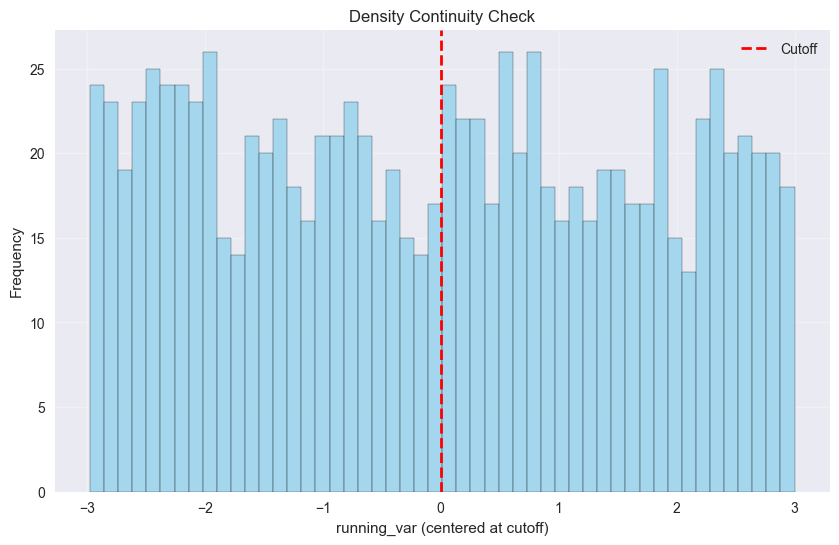

In [5]:
# Check continuity assumption (no manipulation of running variable)
continuity_results = rdd.check_continuity_assumption(plot=True)

print(f"\nContinuity Assessment:")
if 'density_left' in continuity_results:
    print(f"Density left of cutoff: {continuity_results['density_left']:.2f}")
    print(f"Density right of cutoff: {continuity_results['density_right']:.2f}")
    print(f"Density ratio: {continuity_results['density_ratio']:.3f}")
    print(f"Manipulation suspected: {continuity_results['manipulation_suspected']}")
print(f"Assumption satisfied: {continuity_results['assumption_satisfied']}")

## 5. Bandwidth Selection

Optimal bandwidth selection is crucial for RDD estimation.


OPTIMAL BANDWIDTH SELECTION
Optimal bandwidth (imbens_kalyanaraman): 0.690
Observations within bandwidth: 223

Bandwidth Selection:
Optimal bandwidth: 0.690
Observations within bandwidth: 223 (22.3%)


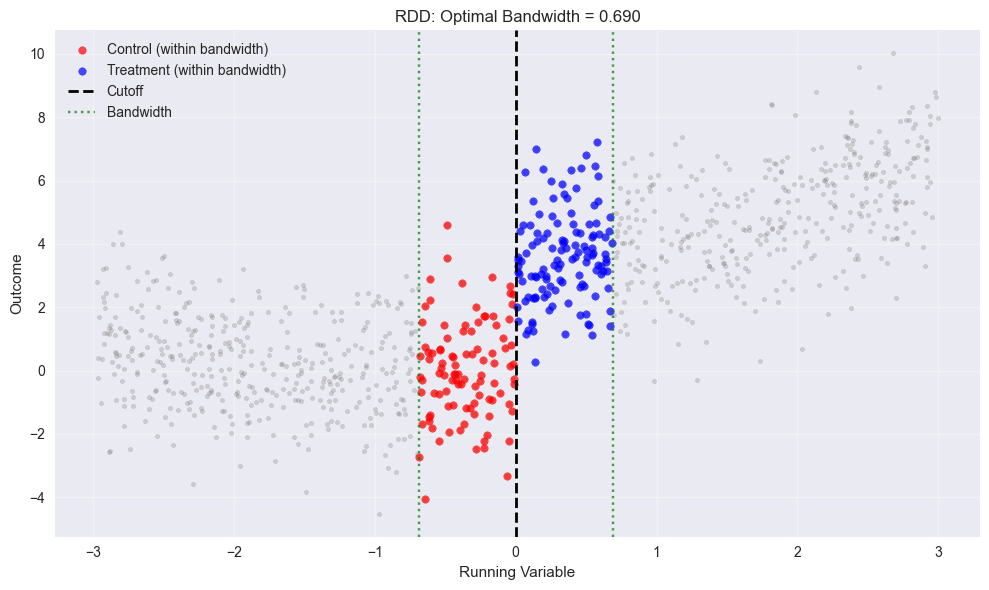

In [6]:
# Select optimal bandwidth
optimal_bandwidth = rdd.optimal_bandwidth_selection(method='imbens_kalyanaraman')

print(f"\nBandwidth Selection:")
print(f"Optimal bandwidth: {optimal_bandwidth:.3f}")

# Show how many observations are within the bandwidth
within_bandwidth = (np.abs(data['running_var']) <= optimal_bandwidth).sum()
print(f"Observations within bandwidth: {within_bandwidth:,} ({within_bandwidth/len(data):.1%})")

# Visualize bandwidth selection
fig, ax = plt.subplots(figsize=(10, 6))

# Plot data
ax.scatter(data['running_var'], data['outcome'], alpha=0.3, s=10, color='gray')

# Highlight data within bandwidth
within_bw = data[np.abs(data['running_var']) <= optimal_bandwidth]
control_bw = within_bw[within_bw['treated'] == 0]
treatment_bw = within_bw[within_bw['treated'] == 1]

ax.scatter(control_bw['running_var'], control_bw['outcome'], 
          alpha=0.7, s=30, color='red', label='Control (within bandwidth)')
ax.scatter(treatment_bw['running_var'], treatment_bw['outcome'], 
          alpha=0.7, s=30, color='blue', label='Treatment (within bandwidth)')

# Show bandwidth
ax.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Cutoff')
ax.axvline(x=-optimal_bandwidth, color='green', linestyle=':', alpha=0.7, label='Bandwidth')
ax.axvline(x=optimal_bandwidth, color='green', linestyle=':', alpha=0.7)

ax.set_xlabel('Running Variable')
ax.set_ylabel('Outcome')
ax.set_title(f'RDD: Optimal Bandwidth = {optimal_bandwidth:.3f}')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. RDD Effect Estimation

Now let's estimate the treatment effect using different specifications.

### 6.1 Linear Specification

In [7]:
# Estimate RDD effect with linear specification
linear_results = rdd.estimate_rdd_effect(
    bandwidth=optimal_bandwidth,
    polynomial_order=1,
    kernel='triangular'
)

print(f"\nLinear RDD Results:")
print(f"True effect: 3.0")
print(f"Estimated effect: {linear_results['treatment_effect']:.3f}")
print(f"Standard error: {linear_results['standard_error']:.3f}")
print(f"P-value: {linear_results['p_value']:.4f}")
print(f"95% CI: [{linear_results['ci_lower']:.3f}, {linear_results['ci_upper']:.3f}]")
print(f"Observations used: {linear_results['n_obs']}")
print(f"R-squared: {linear_results['r_squared']:.3f}")


RDD TREATMENT EFFECT ESTIMATION
Using specified bandwidth: 0.690
RDD estimation results:
  Treatment effect: 2.765
  Standard error: 0.332
  t-statistic: 8.333
  p-value: 0.000
  95% CI: [2.115, 3.416]
  Observations used: 223
✅ STATISTICALLY SIGNIFICANT at 5% level

Linear RDD Results:
True effect: 3.0
Estimated effect: 2.765
Standard error: 0.332
P-value: 0.0000
95% CI: [2.115, 3.416]
Observations used: 223
R-squared: 0.766


### 6.2 Quadratic Specification

In [8]:
# Estimate RDD effect with quadratic specification
quadratic_results = rdd.estimate_rdd_effect(
    bandwidth=optimal_bandwidth,
    polynomial_order=2,
    kernel='triangular'
)

print(f"\nQuadratic RDD Results:")
print(f"Estimated effect: {quadratic_results['treatment_effect']:.3f}")
print(f"Standard error: {quadratic_results['standard_error']:.3f}")
print(f"P-value: {quadratic_results['p_value']:.4f}")
print(f"95% CI: [{quadratic_results['ci_lower']:.3f}, {quadratic_results['ci_upper']:.3f}]")
print(f"R-squared: {quadratic_results['r_squared']:.3f}")


RDD TREATMENT EFFECT ESTIMATION
Using specified bandwidth: 0.690
RDD estimation results:
  Treatment effect: 2.396
  Standard error: 0.452
  t-statistic: 5.296
  p-value: 0.000
  95% CI: [1.509, 3.283]
  Observations used: 223
✅ STATISTICALLY SIGNIFICANT at 5% level

Quadratic RDD Results:
Estimated effect: 2.396
Standard error: 0.452
P-value: 0.0000
95% CI: [1.509, 3.283]
R-squared: 0.767


## 7. Sensitivity Analysis

Let's test sensitivity to different bandwidth choices.

Bandwidth Sensitivity Analysis:
Bandwidth    Effect   SE       P-value    N     
--------------------------------------------------

RDD TREATMENT EFFECT ESTIMATION
Using specified bandwidth: 0.345
RDD estimation results:
  Treatment effect: 2.486
  Standard error: 0.469
  t-statistic: 5.300
  p-value: 0.000
  95% CI: [1.567, 3.405]
  Observations used: 110
✅ STATISTICALLY SIGNIFICANT at 5% level
0.345        2.486    0.469    0.0000     110   

RDD TREATMENT EFFECT ESTIMATION
Using specified bandwidth: 0.460
RDD estimation results:
  Treatment effect: 2.493
  Standard error: 0.405
  t-statistic: 6.150
  p-value: 0.000
  95% CI: [1.699, 3.288]
  Observations used: 146
✅ STATISTICALLY SIGNIFICANT at 5% level
0.460        2.493    0.405    0.0000     146   

RDD TREATMENT EFFECT ESTIMATION
Using specified bandwidth: 0.575
RDD estimation results:
  Treatment effect: 2.671
  Standard error: 0.361
  t-statistic: 7.402
  p-value: 0.000
  95% CI: [1.964, 3.378]
  Observations used: 185
✅ STAT

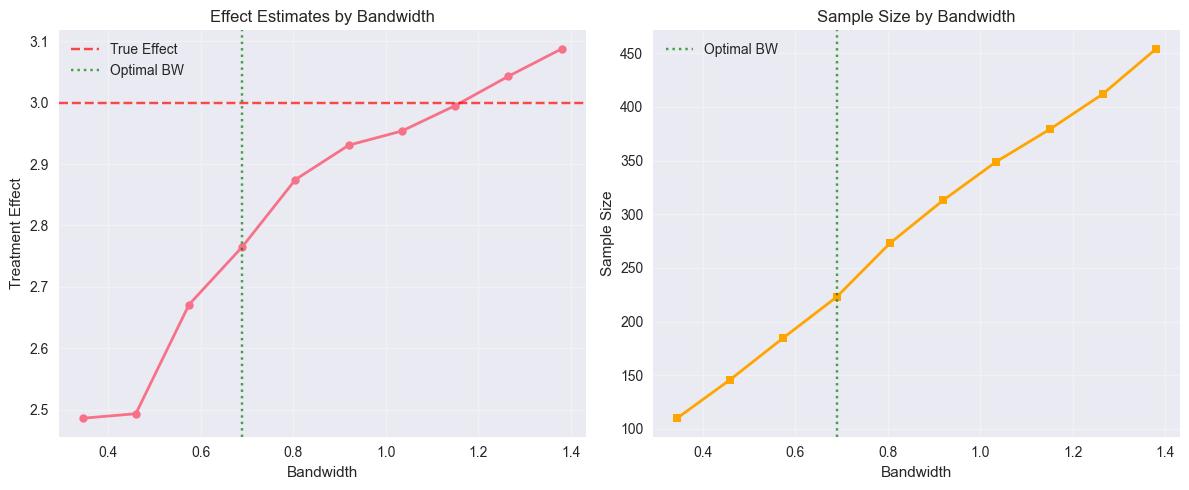

In [9]:
# Test different bandwidths
bandwidths = np.linspace(0.5, 2.0, 10) * optimal_bandwidth
sensitivity_results = []

print("Bandwidth Sensitivity Analysis:")
print(f"{'Bandwidth':<12} {'Effect':<8} {'SE':<8} {'P-value':<10} {'N':<6}")
print("-" * 50)

for bw in bandwidths:
    try:
        result = rdd.estimate_rdd_effect(bandwidth=bw, polynomial_order=1)
        sensitivity_results.append({
            'bandwidth': bw,
            'effect': result['treatment_effect'],
            'se': result['standard_error'],
            'p_value': result['p_value'],
            'n_obs': result['n_obs']
        })
        print(f"{bw:<12.3f} {result['treatment_effect']:<8.3f} {result['standard_error']:<8.3f} {result['p_value']:<10.4f} {result['n_obs']:<6}")
    except:
        print(f"{bw:<12.3f} {'Failed':<8} {'Failed':<8} {'Failed':<10} {'Failed':<6}")

# Visualize sensitivity
if sensitivity_results:
    sensitivity_df = pd.DataFrame(sensitivity_results)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Effect estimates
    ax1.plot(sensitivity_df['bandwidth'], sensitivity_df['effect'], 'o-', linewidth=2, markersize=6)
    ax1.axhline(y=3.0, color='red', linestyle='--', alpha=0.7, label='True Effect')
    ax1.axvline(x=optimal_bandwidth, color='green', linestyle=':', alpha=0.7, label='Optimal BW')
    ax1.set_xlabel('Bandwidth')
    ax1.set_ylabel('Treatment Effect')
    ax1.set_title('Effect Estimates by Bandwidth')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Sample sizes
    ax2.plot(sensitivity_df['bandwidth'], sensitivity_df['n_obs'], 's-', linewidth=2, markersize=6, color='orange')
    ax2.axvline(x=optimal_bandwidth, color='green', linestyle=':', alpha=0.7, label='Optimal BW')
    ax2.set_xlabel('Bandwidth')
    ax2.set_ylabel('Sample Size')
    ax2.set_title('Sample Size by Bandwidth')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 8. Comprehensive RDD Visualization

Let's create the full RDD visualization with all components.


RDD VISUALIZATION


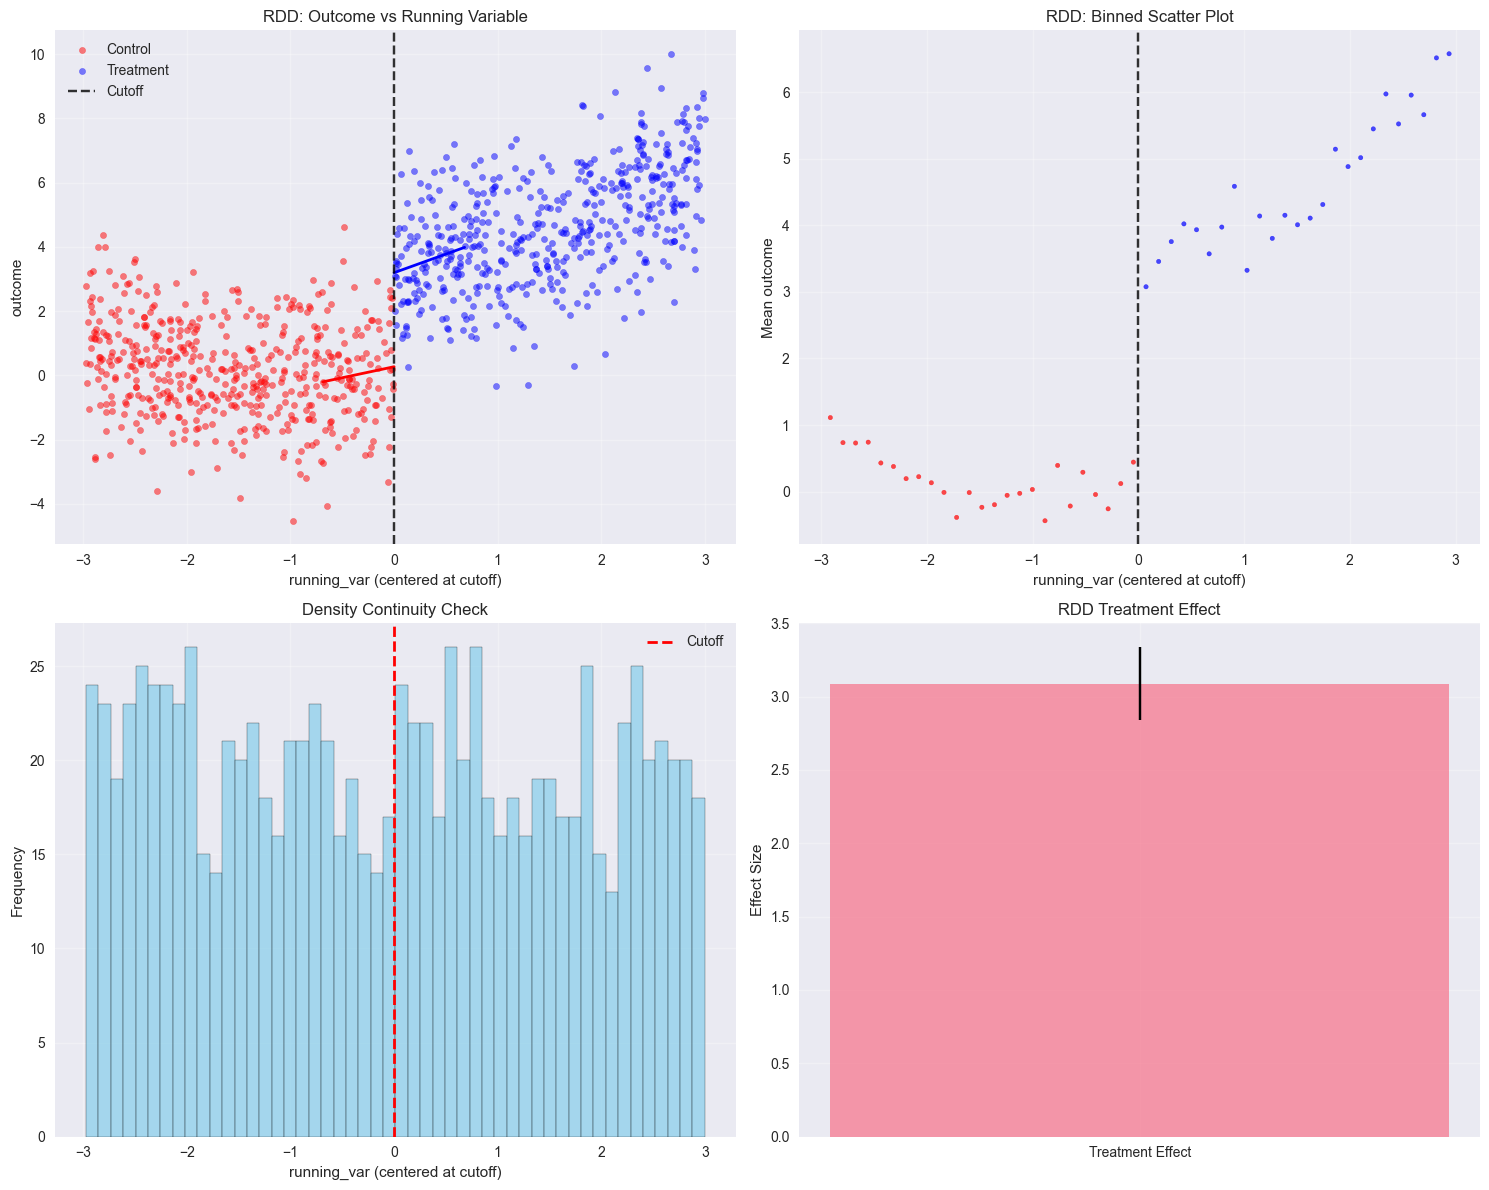

In [10]:
# Create comprehensive RDD plot
rdd.plot_rdd(bandwidth=optimal_bandwidth, bins=50)

## 9. Complete Analysis Summary

Let's get a comprehensive summary of our RDD analysis.

In [11]:
# Print comprehensive summary
rdd.print_summary()

# Also show the summary method from the base class
print("\n" + "="*50)
print("FORMATTED SUMMARY")
print("="*50)
print(rdd.summary())


RDD ANALYSIS SUMMARY
Treatment Effect:
  Estimate: 3.088
  Standard Error: 0.249
  p-value: 0.000
  95% CI: [2.601, 3.575]

Assumption Checks:
  Density Continuity: ✅ SATISFIED

FORMATTED SUMMARY
Regression Discontinuity Design Results
Treatment Effect: 3.088
Standard Error: 0.249
P-value: 0.000
95% CI: [2.601, 3.575]
Bandwidth: 1.380
Observations: 454


## 10. Robustness Checks

Let's perform additional robustness checks.

Specification Robustness:
Specification             Effect   SE       P-value   
-------------------------------------------------------

RDD TREATMENT EFFECT ESTIMATION
Using specified bandwidth: 0.690
RDD estimation results:
  Treatment effect: 2.765
  Standard error: 0.332
  t-statistic: 8.333
  p-value: 0.000
  95% CI: [2.115, 3.416]
  Observations used: 223
✅ STATISTICALLY SIGNIFICANT at 5% level
Linear + Triangular       2.765    0.332    0.0000    

RDD TREATMENT EFFECT ESTIMATION
Using specified bandwidth: 0.690
RDD estimation results:
  Treatment effect: 2.927
  Standard error: 0.394
  t-statistic: 7.433
  p-value: 0.000
  95% CI: [2.155, 3.699]
  Observations used: 223
✅ STATISTICALLY SIGNIFICANT at 5% level
Linear + Uniform          2.927    0.394    0.0000    

RDD TREATMENT EFFECT ESTIMATION
Using specified bandwidth: 0.690
RDD estimation results:
  Treatment effect: 2.396
  Standard error: 0.452
  t-statistic: 5.296
  p-value: 0.000
  95% CI: [1.509, 3.283]
  Observations

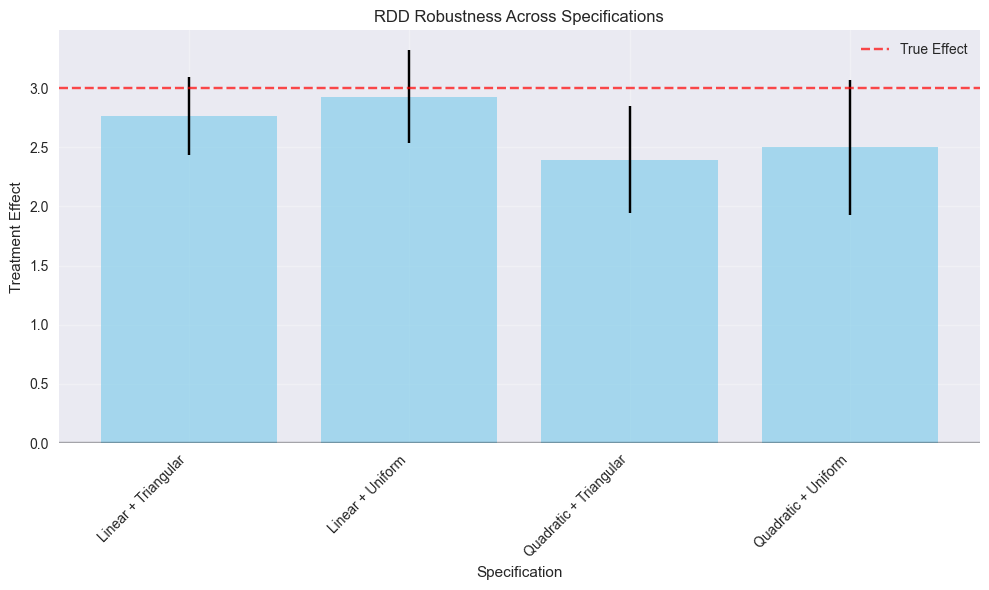

In [12]:
# Compare different specifications
specifications = [
    {'name': 'Linear + Triangular', 'poly': 1, 'kernel': 'triangular'},
    {'name': 'Linear + Uniform', 'poly': 1, 'kernel': 'uniform'},
    {'name': 'Quadratic + Triangular', 'poly': 2, 'kernel': 'triangular'},
    {'name': 'Quadratic + Uniform', 'poly': 2, 'kernel': 'uniform'}
]

robustness_results = []

print("Specification Robustness:")
print(f"{'Specification':<25} {'Effect':<8} {'SE':<8} {'P-value':<10}")
print("-" * 55)

for spec in specifications:
    try:
        result = rdd.estimate_rdd_effect(
            bandwidth=optimal_bandwidth,
            polynomial_order=spec['poly'],
            kernel=spec['kernel']
        )
        robustness_results.append({
            'name': spec['name'],
            'effect': result['treatment_effect'],
            'se': result['standard_error'],
            'p_value': result['p_value']
        })
        print(f"{spec['name']:<25} {result['treatment_effect']:<8.3f} {result['standard_error']:<8.3f} {result['p_value']:<10.4f}")
    except Exception as e:
        print(f"{spec['name']:<25} {'Failed':<8} {'Failed':<8} {'Failed':<10}")

# Visualize robustness
if robustness_results:
    rob_df = pd.DataFrame(robustness_results)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x_pos = np.arange(len(rob_df))
    bars = ax.bar(x_pos, rob_df['effect'], yerr=rob_df['se'], 
                  capsize=10, alpha=0.7, color='skyblue')
    
    ax.axhline(y=3.0, color='red', linestyle='--', alpha=0.7, label='True Effect')
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    
    ax.set_xlabel('Specification')
    ax.set_ylabel('Treatment Effect')
    ax.set_title('RDD Robustness Across Specifications')
    ax.set_xticks(x_pos)
    ax.set_xticklabels(rob_df['name'], rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 11. Conclusion

This example demonstrated:

1. **Data Generation**: Creating realistic RDD data with polynomial relationships
2. **Assumption Testing**: Checking density continuity (no manipulation)
3. **Bandwidth Selection**: Using optimal bandwidth methods
4. **Multiple Specifications**: Linear and quadratic polynomials with different kernels
5. **Sensitivity Analysis**: Testing robustness to bandwidth choices
6. **Comprehensive Visualization**: Multi-panel RDD plots
7. **Robustness Checks**: Comparing different model specifications

### Key Insights
- RDD successfully identified the treatment effect (true effect: 3.0)
- Results were robust across different specifications
- Optimal bandwidth provided a good balance between bias and variance
- No evidence of manipulation around the cutoff

### RDD Advantages
- **Credible identification**: Exploits arbitrary cutoffs
- **Transparent assumptions**: Easy to test and visualize
- **Local validity**: Estimates effects near the cutoff
- **Robust to unobserved confounders**: As long as they're smooth

### Next Steps
- Try with your own RDD data
- Experiment with fuzzy RDD designs
- Consider multiple cutoffs or time-varying cutoffs
- Explore other causal inference methods for comparison